In [70]:
from seffaflik.elektrik.tuketim import gerceklesen
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

### Tüketim datasının epiaş şeffalıktan alınması

In [73]:
start_date = '2016-01-01'
df = gerceklesen(start_date).iloc[:-1,:]
df['Tarih'] = pd.to_datetime(df['Tarih']) + pd.to_timedelta(df['Saat'], unit='h')
df.drop(columns='Saat', inplace=True)
df.rename(columns={'Tarih': 'date', 'Tüketim': 'consumption'}, inplace=True)
df = df.set_index('date')
df.head()

,consumption
date,
2016-01-01 00:00:00,26277.24
2016-01-01 01:00:00,24991.82
2016-01-01 02:00:00,23532.61
2016-01-01 03:00:00,22464.78
2016-01-01 04:00:00,22002.91


In [74]:
# Tüketimin yıllara göre değişimi
cm = sns.light_palette("brown", as_cmap=True)
df.groupby(by=df.index.year).describe().style.background_gradient(cmap=cm).set_precision(2)


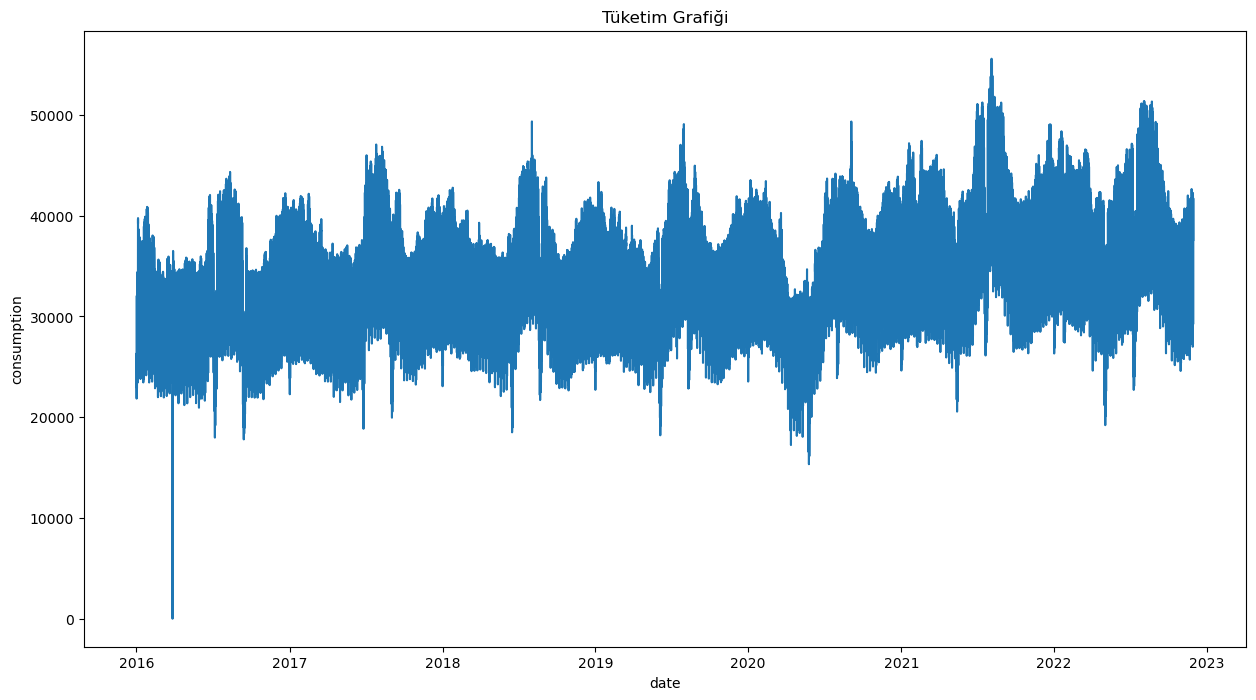

In [75]:
# Tüketimin genel davranışı
plt.figure(figsize=(15,8))
sns.lineplot(x=df.index, y=df.consumption)
plt.title('Tüketim Grafiği')
plt.show()

Text(0.5, 1.0, '2021')

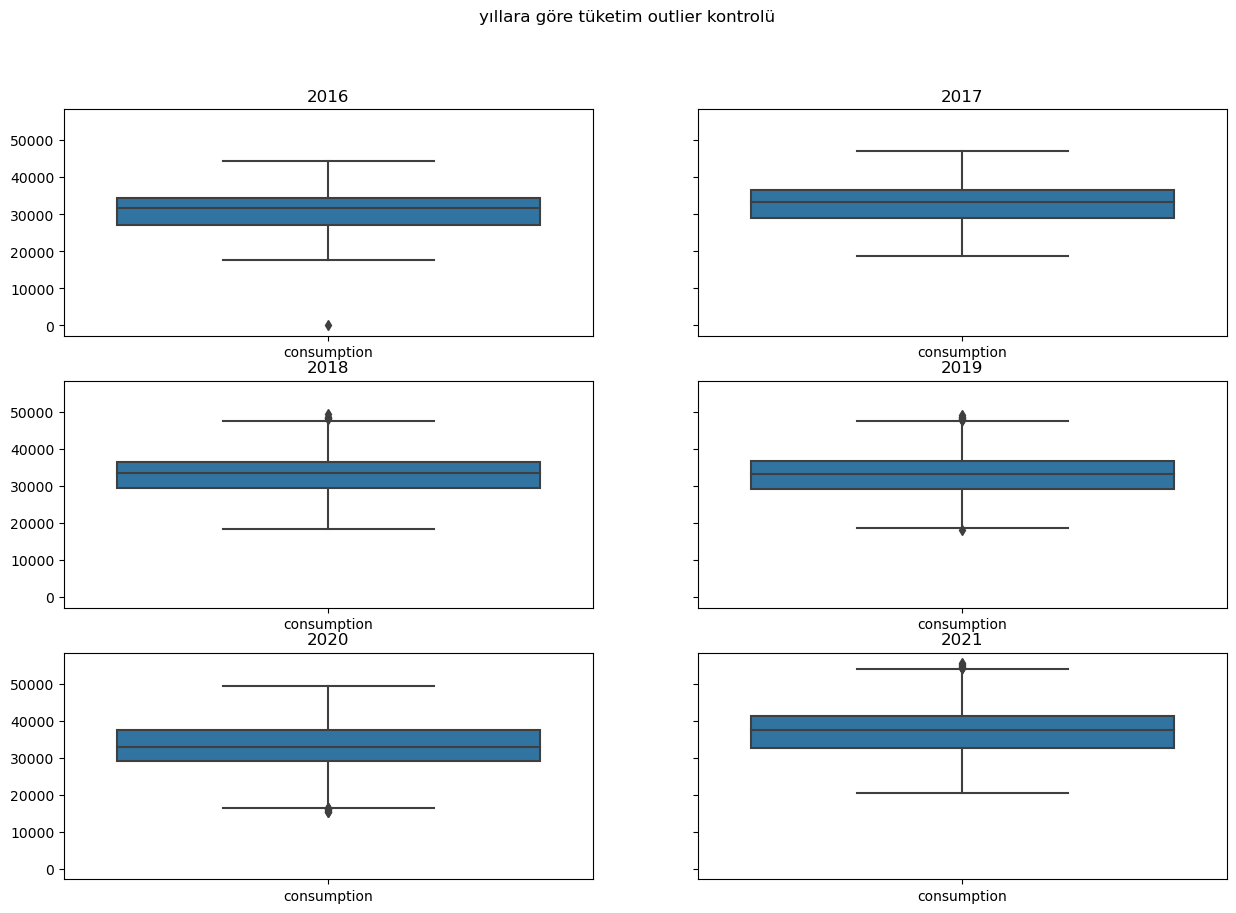

In [76]:
# yıllara tüketimdeki outlier değerlerin görselleştirilmesi 
# 2022 henüz tamamlanmadığı için dahil edilmemiştir
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharey=True)
fig.suptitle('yıllara göre tüketim outlier kontrolü')

sns.boxplot(ax=axes[0,0],data=df[df.index.year == 2016])   
axes[0,0].set_title('2016')

sns.boxplot(ax=axes[0,1],data=df[df.index.year == 2017])   
axes[0,1].set_title('2017')

sns.boxplot(ax=axes[1,0],data=df[df.index.year == 2018])   
axes[1,0].set_title('2018')

sns.boxplot(ax=axes[1,1],data=df[df.index.year == 2019])   
axes[1,1].set_title('2019')

sns.boxplot(ax=axes[2,0],data=df[df.index.year == 2020])   
axes[2,0].set_title('2020')

sns.boxplot(ax=axes[2,1],data=df[df.index.year == 2021])   
axes[2,1].set_title('2021')

##### Yıllara göre outlier değerlerin tarihlerinin tespit edilmesi

###### Eğer tarihlerde birbirini tekrarlayan tarihler var ise bunların tespit edeilip tahmin yapılırken tespit edilen tarihlere dikkat edilmesi gerekir. Bu veriler datadan çıkarılır veya daha makul değerler ile doldurulabilir.

In [77]:
def iqr_calc(df):
    q1 , q3 = np.percentile(df, [24, 75])
    iqr = q3 - q1
    lower, upper = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
    return lower, upper

years_outlier = pd.DataFrame(columns=['consumption'])
for year in range(2016,2022):
    tmp_df = df[df.index.year == year]
    lower, upper = iqr_calc(tmp_df)

    outlier_data = tmp_df[(tmp_df.consumption > upper) | (tmp_df.consumption < lower)]
    years_outlier = pd.concat([years_outlier,outlier_data])

years_outlier

,consumption
2016-03-27 02:00:00,0.00
2018-08-02 11:00:00,48435.57
2018-08-02 13:00:00,48505.70
2018-08-02 14:00:00,49352.70
2018-08-02 15:00:00,48714.57
2018-08-02 16:00:00,48081.13
2019-07-29 14:00:00,48293.41
2019-07-30 14:00:00,48608.31
2019-07-30 15:00:00,48066.41
2019-07-31 13:00:00,48022.43


##### Yıllara göre datanın dağılımı
###### datanın dağılımını kontrol edip nasıl birşey tahminlemeye çalıştığımı anlamaya çalışıyoruz
###### Normal dağılım mı Bernoulli mi vs. 

Text(0.5, 1.0, '2021')

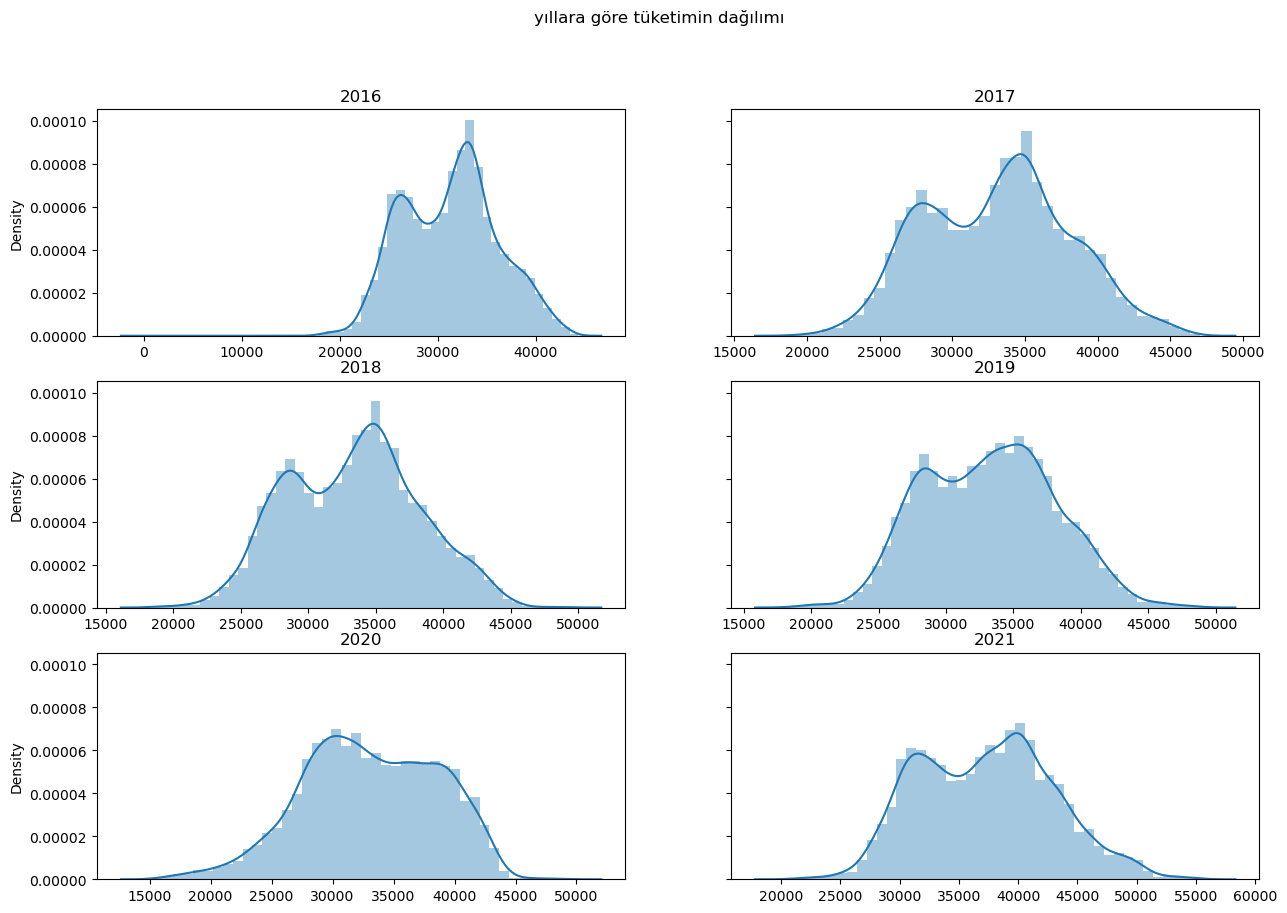

In [78]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharey=True)
fig.suptitle('yıllara göre tüketimin dağılımı')

sns.distplot(df[df.index.year == 2016],ax=axes[0,0])   
axes[0,0].set_title('2016')

sns.distplot(df[df.index.year == 2017],ax=axes[0,1])   
axes[0,1].set_title('2017')

sns.distplot(df[df.index.year == 2018],ax=axes[1,0])   
axes[1,0].set_title('2018')

sns.distplot(df[df.index.year == 2019],ax=axes[1,1])   
axes[1,1].set_title('2019')

sns.distplot(df[df.index.year == 2020],ax=axes[2,0])   
axes[2,0].set_title('2020')

sns.distplot(df[df.index.year == 2021],ax=axes[2,1])   
axes[2,1].set_title('2021')

<AxesSubplot:xlabel='date'>

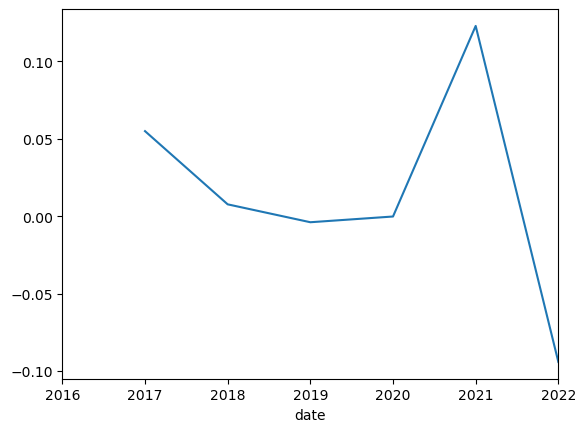

In [79]:
# yıllara göre tüketimin nasıl değiştiğini görselleştirelim
# 2022 yılı henüz tamamlanmadığı için tüketimin 2021 yılına göre düştüğü görünmektedir.
df['consumption'].resample('y').sum().pct_change().plot()

##### Verimizin trend ve mevsimselliğini statsmodels aracılığıyla görselleştiriyoruz
###### verimizde 2020 yılından sonra tüketimin arttığı, mevsimsel davranışların olduğu 


###### aynı zamanda outlier değerler gözlenmiştir

###### Verilerin hem trend hem de mevsimselliğe sahip olması verilerin durağan olmadığı anlamına gelir

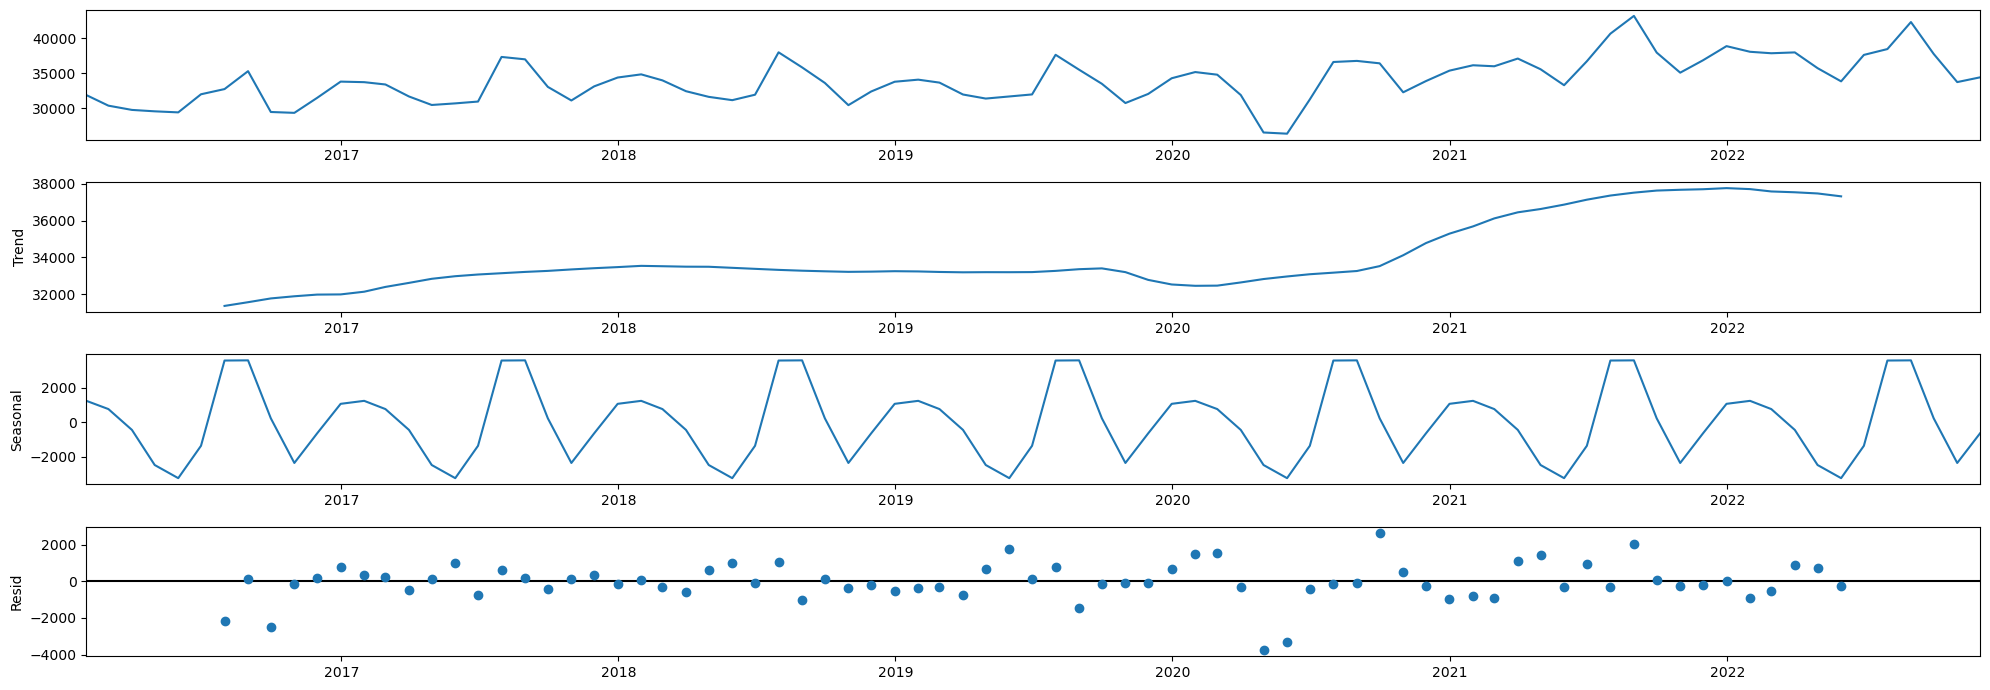

In [6]:
data_monthly = df.resample('m').mean()
plt.rcParams['figure.figsize'] = [20,7]
decomposition = sm.tsa.seasonal_decompose(data_monthly)
fig = decomposition.plot()
plt.show()

## ACF ve PACF Grafikleri

###### Zaman serileri analizinde verilerin otokorelasyon ve kısmı otokorelasyon grafiğinin incelenmesi önemli bir adımdır. Model terimlerinin sayısını belirlemek için Otokorelasyon fonksiyonu (ACF) ve kısmi otokorelasyon fonksiyonu (PACF) grafiklerinden yararlanacağız.

###### Verilerin çizgi grafiği, zaman serileri bileşenleri ve ACF-PACF grafiğinden yola çıkarak serinin durağan olmadığını söyleyebiliriz.

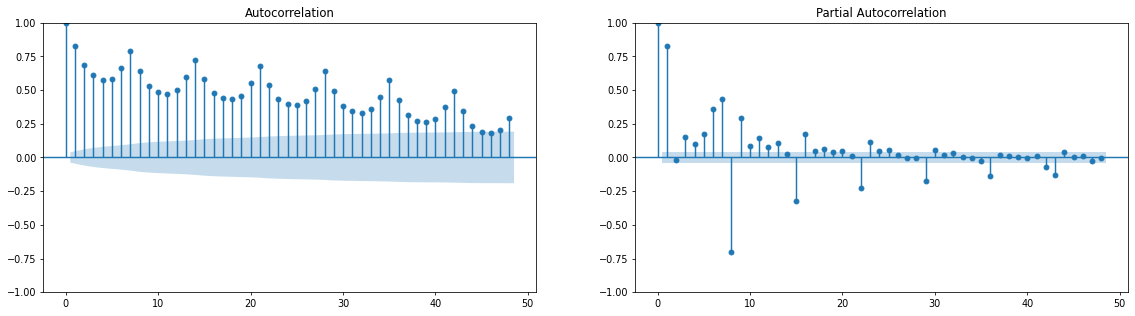

In [7]:
data_daily = df.resample('d').mean()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)
sm.graphics.tsa.plot_acf(data_daily.consumption.tolist(), ax=ax1, lags=48)
sm.graphics.tsa.plot_pacf(data_daily.consumption.tolist(), ax=ax2, lags=48, method="ywm")
plt.show()